# ASTR 598: Final Project (Tom)

In [57]:
import h5py as h5
import numpy as np
import pandas as pd
from astroML.density_estimation import KNeighborsDensity
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.special import rel_entr, kl_div
import scipy.stats
from pomegranate import GeneralMixtureModel, MultivariateGaussianDistribution

In [2]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Project Background

## Motivation

The general motivation behind this project is to assess whether we have done a good job in creating the LSST Hybrid Catalogue.

This catalogue is a hybrid that contains both real and simulated data. We created it to improve the way in which we make predictions for LSST and to avoid claiming statistics that included "discoveries" of already known objects. I made this catalogue by performing a sort of nearest neighbours search between MPCORB (the real data) and S3M (the simulated data) in order to replace "similar" simulated objects with real counterparts.

Our method replaced objects that were "similar" based on their $(x, y, z)$, $(v_x, v_y, v_z)$ and $H$ values, in order to best preserve the important parameter distributions in the simulated data. **It would be useful to know how well we did at reproducing the underlying simulated data with the real observations.** This is the motivation for this project.

## Outline

In order to assess the quality of the hybrid catalogue in this way I decided to use density estimation and KL divergence.

The general workflow was something like this:

- Try different density estimation methods
    - K Nearest Neighbours
    - Gaussian Mixture Model
- Estimate density of MPCORB (real data) and matched S3M objects (simulated data, objected that will be replaced by MPCORB in the hybrid catalogue)
- Do some basic tests to gauge how KL divergence changes
    - Compare different distributions
    - Compare mixtures of Gaussians
    - Compare Gaussians with different parameters
- Calculate KL divergence of density and evaluate the result

Read on for the details!

# Density Estimation

## Read in the data
For the density estimation, I read in the full mpcorb file and mask the S3m file so that I only make the density for the objects that "matched" with mpcorb objects in the merge (and so should be very similar)

In [3]:
# read in entire MPCORB file that has been propagated and in cartesian coordinates
mpcorb = pd.read_hdf("../catalogues/mpcorb_propagated_cart.h5")

In [4]:
# same for S3M
s3m = pd.read_hdf("../catalogues/s3m_propagated_cart.h5")

In [5]:
# loop over the merge output to get the ids that matched mpcorb
delete_these = []
H_bins = np.arange(-2, 28 + 1)
for left, right in zip(H_bins[:-1], H_bins[1:]):
    matched = np.load("../output/matched_{}_{}.npy".format(left, right))
    delete_these.extend(matched)

In [6]:
# keep only those ids
remaining_s3m = s3m[np.isin(s3m["id"].values, delete_these)]

## Set up the density estimators
For the density estimation, I focussed only on making the density in 3 dimensions (heliocentric x, y, z). I considered also adding in the velocities but I wasn't sure it would be valid comparison since we'd be comparing distances to velocities when finding "nearest" neighbours and I wasn't sure which would be "more important" to the density.

In [7]:
# get just the x, y, z for mpcorb
mpc_xyz = np.array([mpcorb.x, mpcorb.y, mpcorb.z]).T

# create a density estimator and fit to (x, y, z)
mpc_estimator = KNeighborsDensity()
mpc_estimator.fit(mpc_xyz)

# same for S3m
s3m_xyz = np.array([remaining_s3m.x, remaining_s3m.y, remaining_s3m.z]).T

s3m_estimator = KNeighborsDensity()
s3m_estimator.fit(s3m_xyz)

KNeighborsDensity()

## Density over full grid of x, y, z
In this section I calculate the density of the real and simulated objects over a regular grid that covers the entire range of data. I then plot the results and compare them.

In [33]:
# create arrays over x, y, z
x = np.linspace(-100, 100, 100)
y = np.linspace(-75, 75, 101)
z = np.linspace(-47, 47, 102)

# turn them into a grid
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

# flatten the grid into a 1D array for the estimator
grid = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T
grid_shape = X.shape

Here's comes the actual density estimation!

In [34]:
%%time
# calculate density for mpc
mpc_density = mpc_estimator.eval(grid)

CPU times: user 1min 50s, sys: 2.25 s, total: 1min 52s
Wall time: 1min 52s


In [35]:
%%time
# calculate density for S3m
s3m_density = s3m_estimator.eval(grid)

CPU times: user 1min 37s, sys: 1.05 s, total: 1min 38s
Wall time: 1min 38s


In [36]:
# normalise the densities!!!
# thanks to Stephen for pointing out this is necessary :D
mpc_density /= mpc_density.sum()
s3m_density /= s3m_density.sum()

### Plot the results
Below I plot the results of the density estimation. Note that the density is on a log scale and so, although the outskirts of the solar system are different, this is only a small fraction of the population. This motivated me to try zooming in on the inner 5AU instead.

In [16]:
def plot_x_y_density(density, x, y, grid_shape, label, norm=LogNorm(), cmap="magma", fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots()
    
    X, Y = np.meshgrid(x, y)
    img = density.reshape(grid_shape).sum(axis=2).T
    
    ax.annotate(label, xy=(0.98, 0.98), xycoords="axes fraction",
                ha="right", va="top", color="white", fontsize=fs)
    
    mesh = ax.pcolormesh(X, Y, img, shading="nearest", norm=norm, cmap=cmap)
    cbar = fig.colorbar(mesh, label="Density", ax=ax)
    
    ax.set_aspect("equal")
    ax.set_xlabel(r"Heliocentric $x \, [\rm AU]$")
    ax.set_ylabel(r"Heliocentric $y \, [\rm AU]$")
    
    return fig, ax

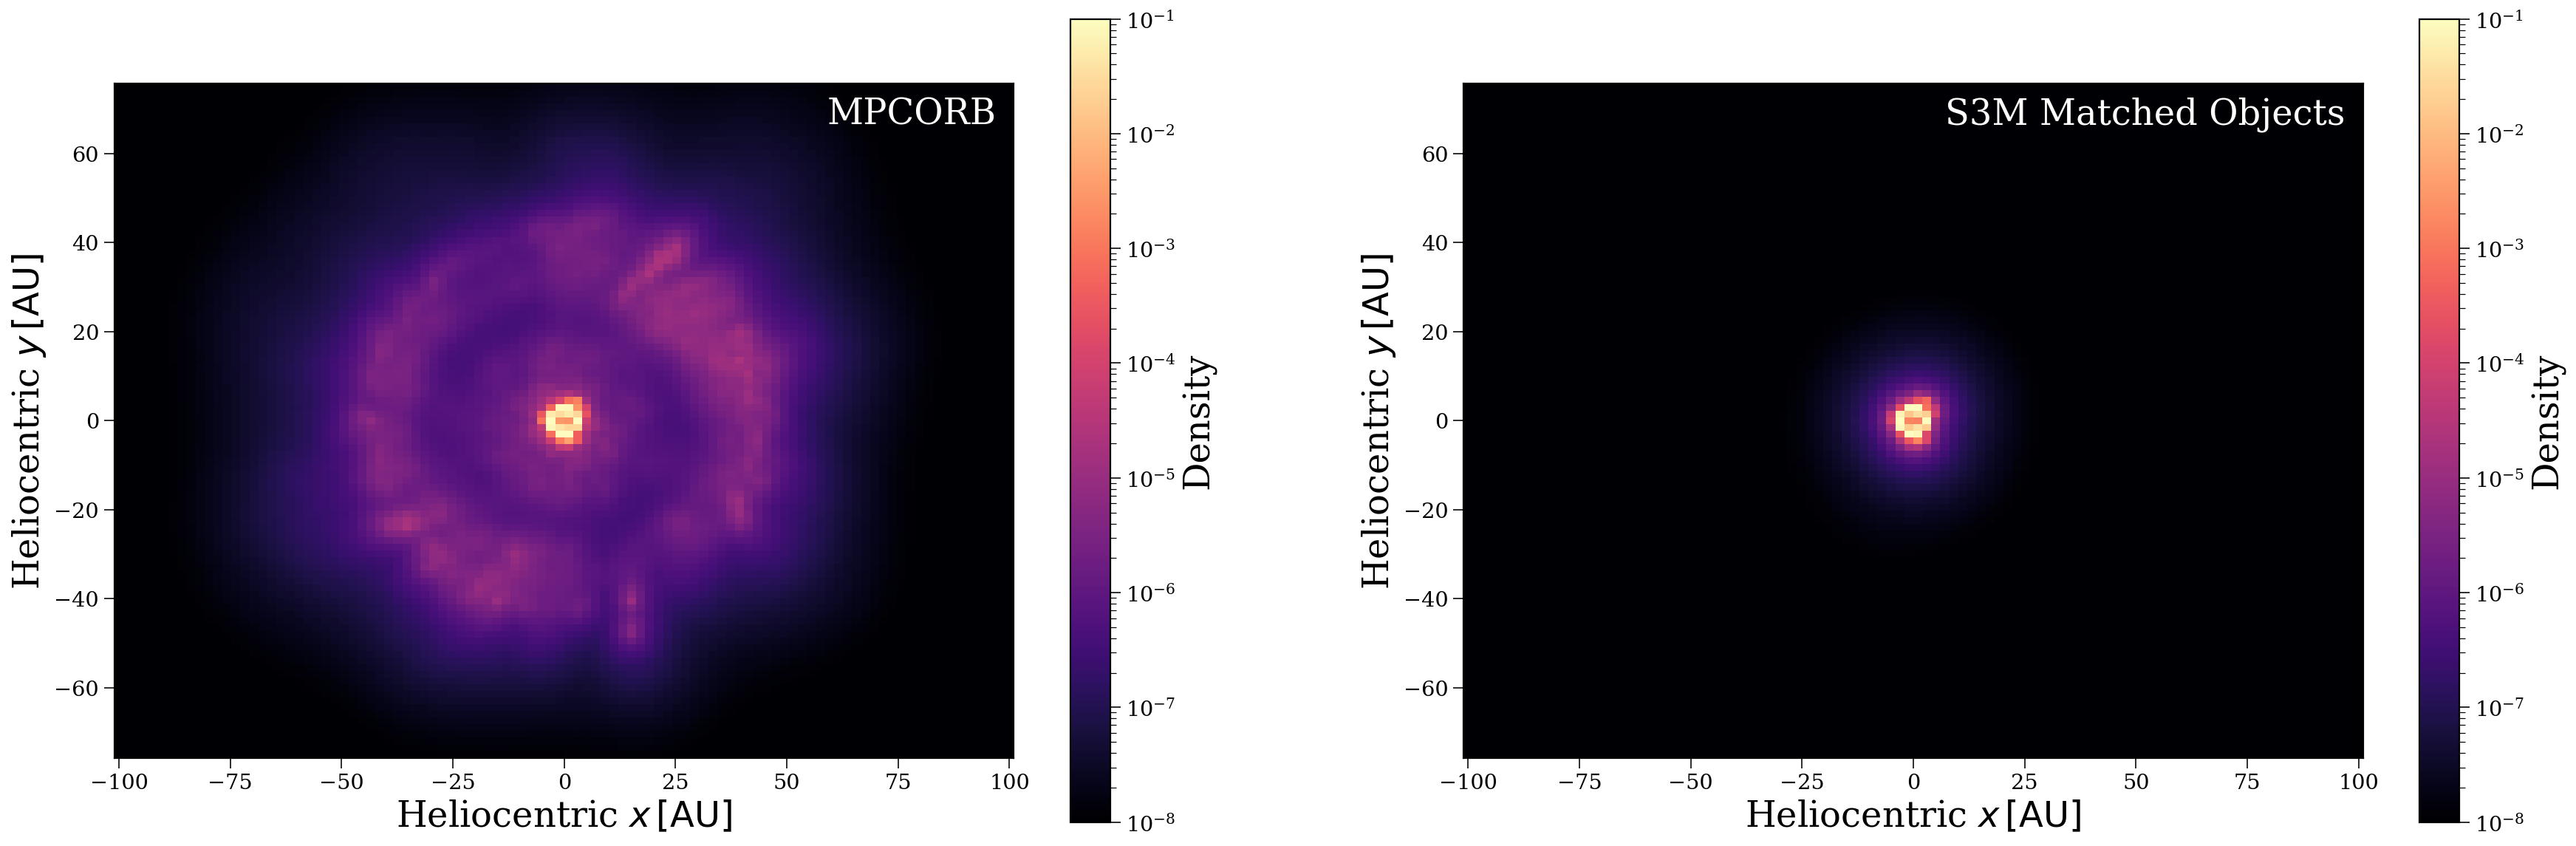

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))

fig, axes[0] = plot_x_y_density(mpc_density, x, y, grid_shape, label="MPCORB",
                                norm=LogNorm(vmin=1e-8, vmax=1e-1), fig=fig, ax=axes[0])
fig, axes[1] = plot_x_y_density(s3m_density, x, y, grid_shape, label="S3M Matched Objects",
                                norm=LogNorm(vmin=1e-8, vmax=1e-1), fig=fig, ax=axes[1])

plt.show()

## Zoomed in density (only inner 5AU and 3AU in height)
This code does the same as above but now I focus on only the inner solar system where the majority of the density is contained.

In [38]:
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

# just to quickly show that most of the density is here
mask = np.logical_and.reduce((X >= -5, X <= 5,
                              Y >= -5, Y <= 5,
                              Z >= -3, Z <= 3,))
print("{:1.1f}% of the original density is contained in the next grid".format(mpc_density.reshape(grid_shape)[mask].sum() * 100))

99.2% of the original density is contained in the next grid


In [39]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 101)
z = np.linspace(-3, 3, 102)

X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
grid = np.array([X.ravel(),Y.ravel(),Z.ravel()]).T
grid_shape = X.shape

In [40]:
%%time
mpc_density_zoomed = mpc_estimator.eval(grid)

CPU times: user 8min 42s, sys: 10.8 s, total: 8min 53s
Wall time: 8min 53s


In [41]:
%%time
s3m_density_zoomed = s3m_estimator.eval(grid)

CPU times: user 4min 9s, sys: 4.1 s, total: 4min 13s
Wall time: 4min 14s


In [42]:
mpc_density_zoomed /= mpc_density_zoomed.sum()
s3m_density_zoomed /= s3m_density_zoomed.sum()

### Plotting: Zoomed in
And now the plots look much more similar!

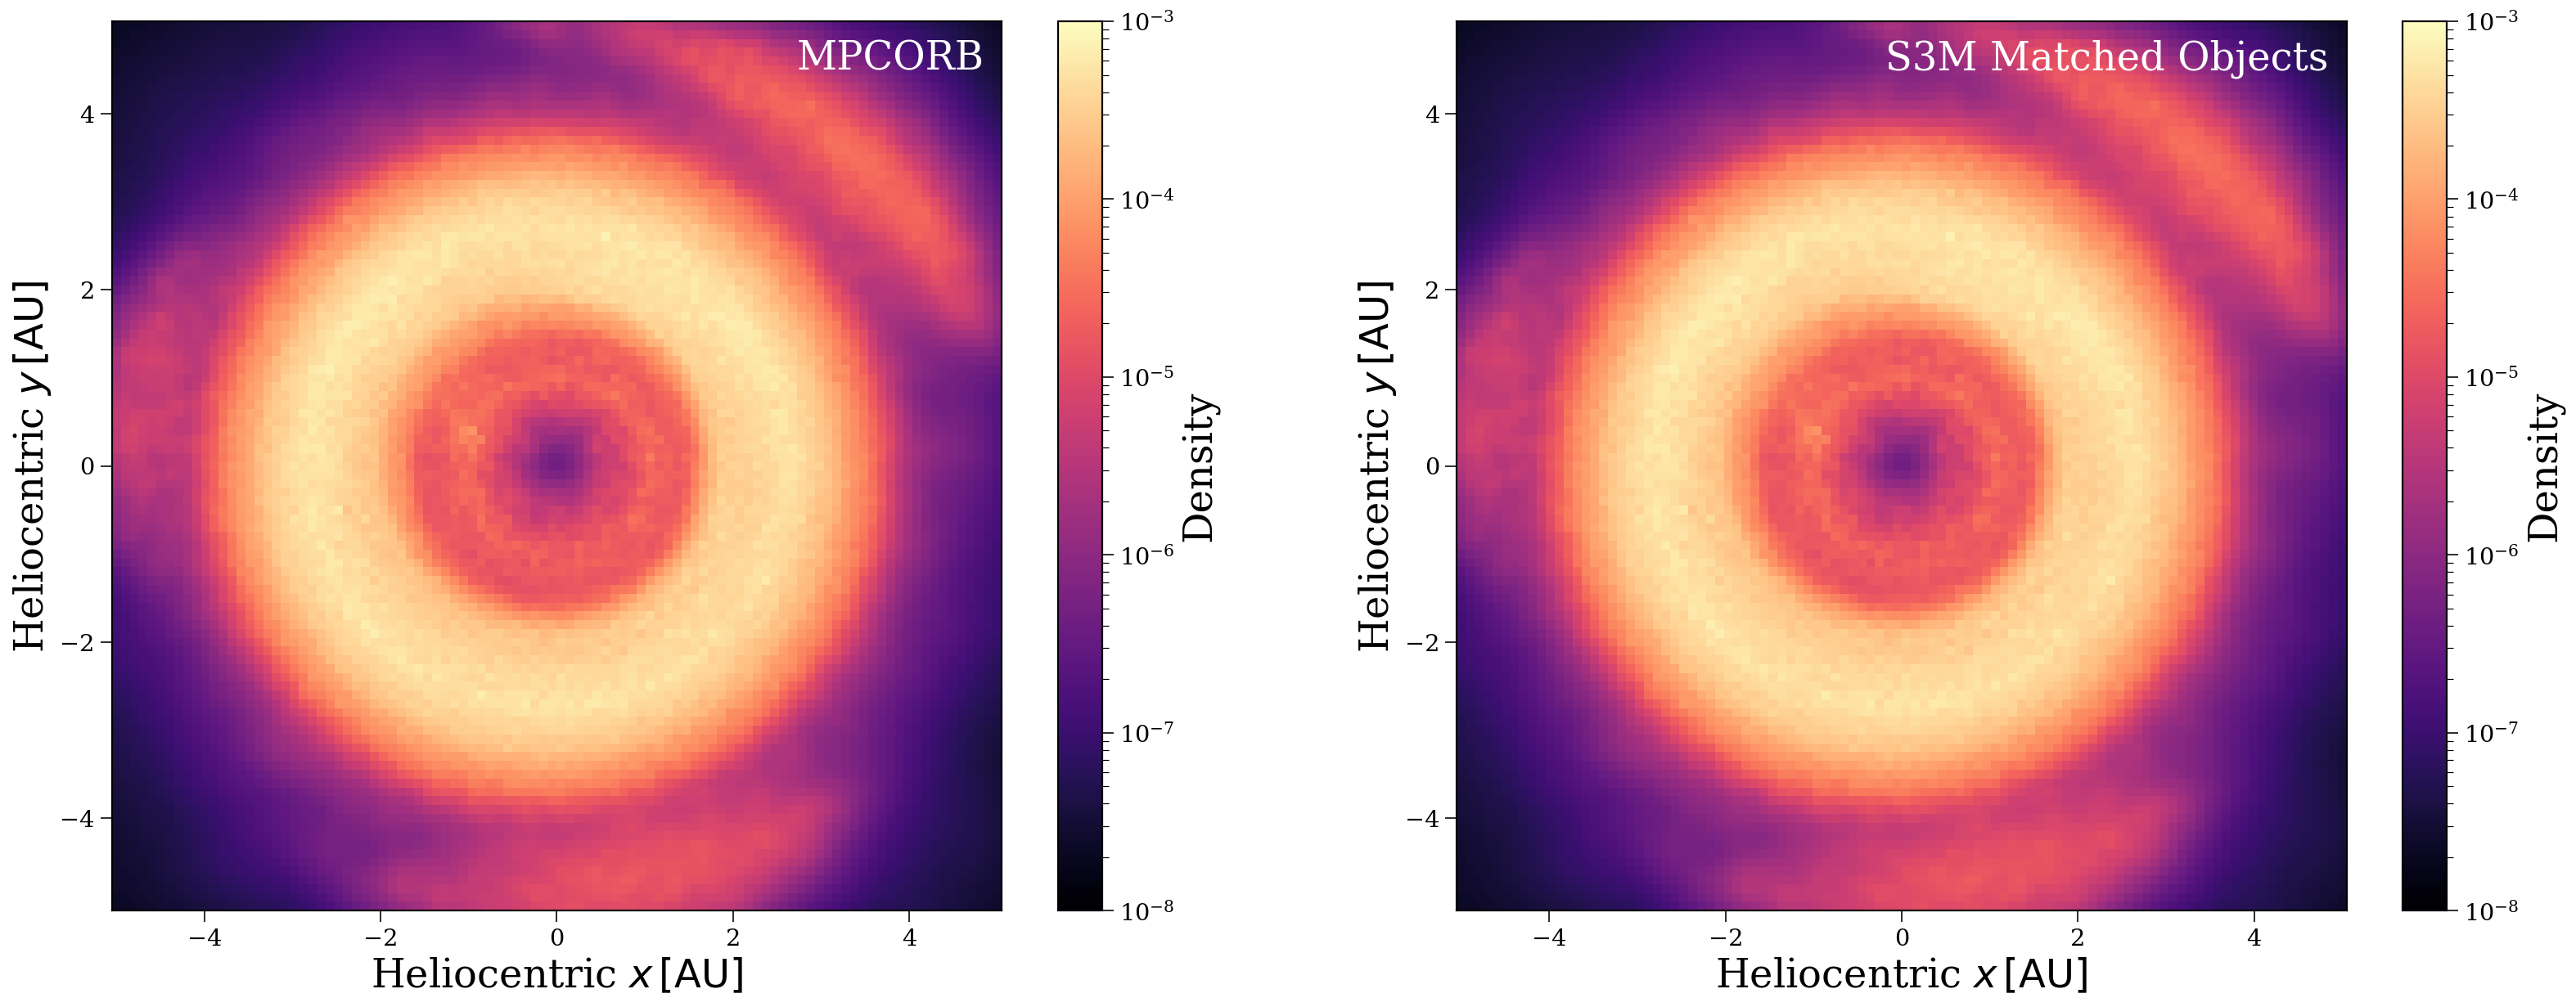

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(27, 10))

fig, axes[0] = plot_x_y_density(mpc_density_zoomed, x, y, grid_shape, label="MPCORB",
                                norm=LogNorm(vmin=1e-8, vmax=1e-3), fig=fig, ax=axes[0])
fig, axes[1] = plot_x_y_density(mpc_density_zoomed, x, y, grid_shape, label="S3M Matched Objects",
                                norm=LogNorm(vmin=1e-8, vmax=1e-3), fig=fig, ax=axes[1])

plt.show()

## Residuals
Andy (Tzanidakis) suggested that I should take a look at the residuals and I could use those to compare across different density estimation methods. I'm not sure how this is usually done but I calculated the residuals of both the difference between the densities and the **absolute** difference between the densities

In [63]:
res = (mpc_density_zoomed - s3m_density_zoomed).sum()
res

3.227873155396688e-17

In [64]:
abs_res = np.abs(mpc_density_zoomed - s3m_density_zoomed).sum()
abs_res

0.4255503501295571

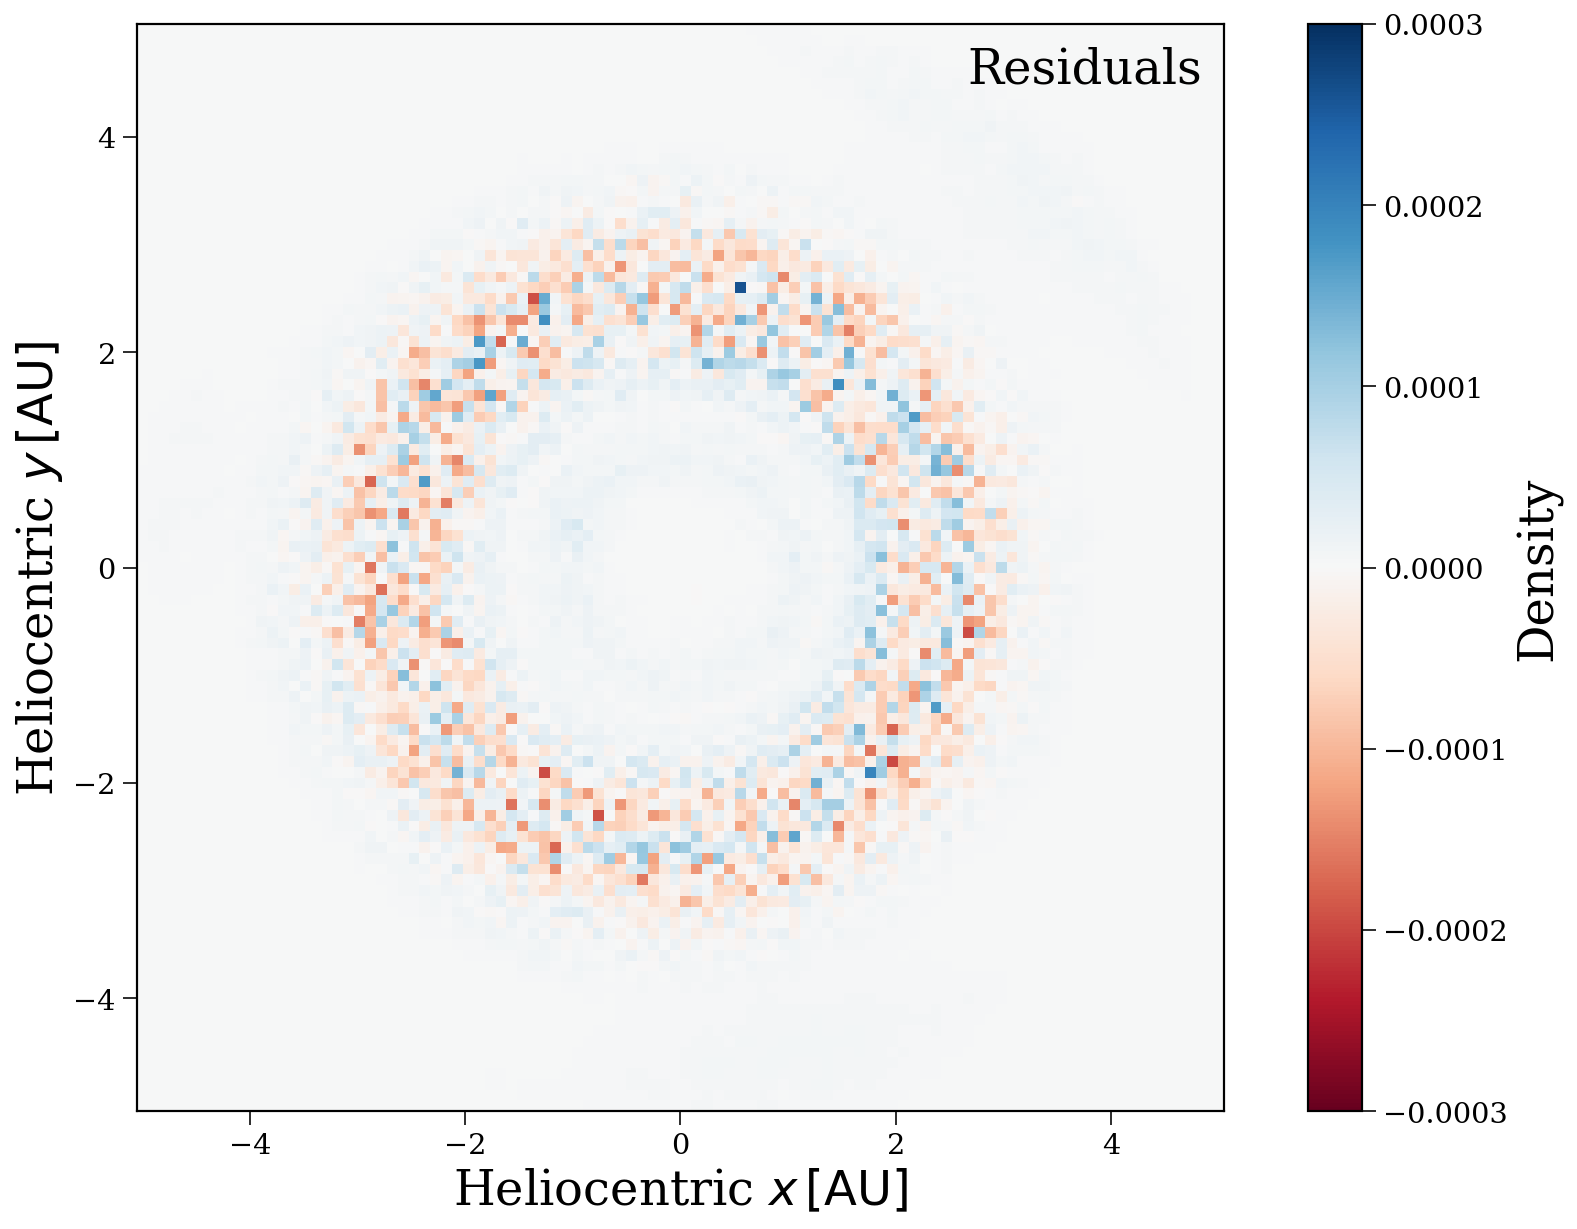

In [62]:
fig, ax = plt.subplots(figsize=(15, 10))

X, Y = np.meshgrid(x, y)
res_img = (mpc_density_zoomed - s3m_density_zoomed).reshape(grid_shape).sum(axis=2).T

ax.annotate("Residuals", xy=(0.98, 0.98), xycoords="axes fraction",
                 ha="right", va="top", color="black", fontsize=fs)

mesh = ax.pcolormesh(X, Y, res_img, shading="nearest", cmap="RdBu", norm=Normalize(vmin=-0.0003, vmax=0.0003))
cbar = fig.colorbar(mesh, label="Density", ax=ax)

ax.set_aspect("equal")
ax.set_xlabel(r"Heliocentric $x \, [\rm AU]$")
ax.set_ylabel(r"Heliocentric $y \, [\rm AU]$")

plt.show()

# Gaussian Mixture Model

Inspired by Andy Tzanidakis I also tried out using a Gaussian Mixture Model for the density estimation. I experiments with a lot of different numbers of Gaussians over different amounts of the data but overall found this to be a worse method. The result seems to be overly smoothed most of the time and not nearly as clear as the K Nearest Neighbours method.

In [12]:
def gen_gmm(x_dat, y_dat, z_dat, grid=None, grid_shape=None, n_gmm=10, step=1,
            grid_size=100, xmin=-5, xmax=5, ymin=-5, ymax=5, zmin=-3, zmax=3):
    """This function will take data and conver it into a GMM convolved grid.
    Original function by Andy Tzandakis, I've modified it to work for 3D and take a grid as input.
    
    Input:
    ------
    x_dat, y_dat, z_dat (np.array): original data you want to apply the GMM
    n_gmm: Number of Gaussian Mixture Model components
    step (int): If your array is too big you can skip every n-th index
    grid (np.array): Grid of points at which to evaluate
    grid_shape (tuple): Shape of grid before it has been flattened
    grid_size (int): Final grid size of your GMM
    xmin...zmax: custom ranges based on the global parameters
    """
    
    # stack the data vertically and trim if wanted
    X_stack = np.vstack([x_dat, y_dat, z_dat]).T
    if step > 1:
        X_stack = X_stack[0:len(X_stack):step]
    
    # create a GMM
    gmm_model = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution,
                                                 n_gmm,
                                                 X_stack)
    
    # generate grid
    if grid is None or grid_shape is None:
        x = np.linspace(xmin, xmax, grid_size)
        y = np.linspace(ymin, ymax, grid_size + 1)
        z = np.linspace(zmin, zmax, grid_size + 2)

        xx, yy, zz = np.meshgrid(x, y, z, indexing="ij")
        grid = np.array(list(zip(xx.flatten(), yy.flatten(), zz.flatten())))
        grid_shape = (grid_size, grid_size + 1, grid_size + 2)

    # estimate probabilities using grid
    p = gmm_model.probability(grid).reshape(grid_shape)
    
    return p

In [31]:
%%time
gmm_mpc = gen_gmm(mpcorb.x, mpcorb.y, mpcorb.z, step=100, n_gmm=100, grid=grid, grid_shape=grid_shape)
gmm_mpc /= gmm_mpc.sum()

CPU times: user 1min 40s, sys: 447 ms, total: 1min 41s
Wall time: 1min 41s


In [32]:
%%time
gmm_s3m = gen_gmm(remaining_s3m.x, remaining_s3m.y, remaining_s3m.z, step=100, n_gmm=100,
                  grid=grid, grid_shape=grid_shape)
gmm_s3m /= gmm_s3m.sum()

CPU times: user 1min 27s, sys: 572 ms, total: 1min 28s
Wall time: 1min 28s


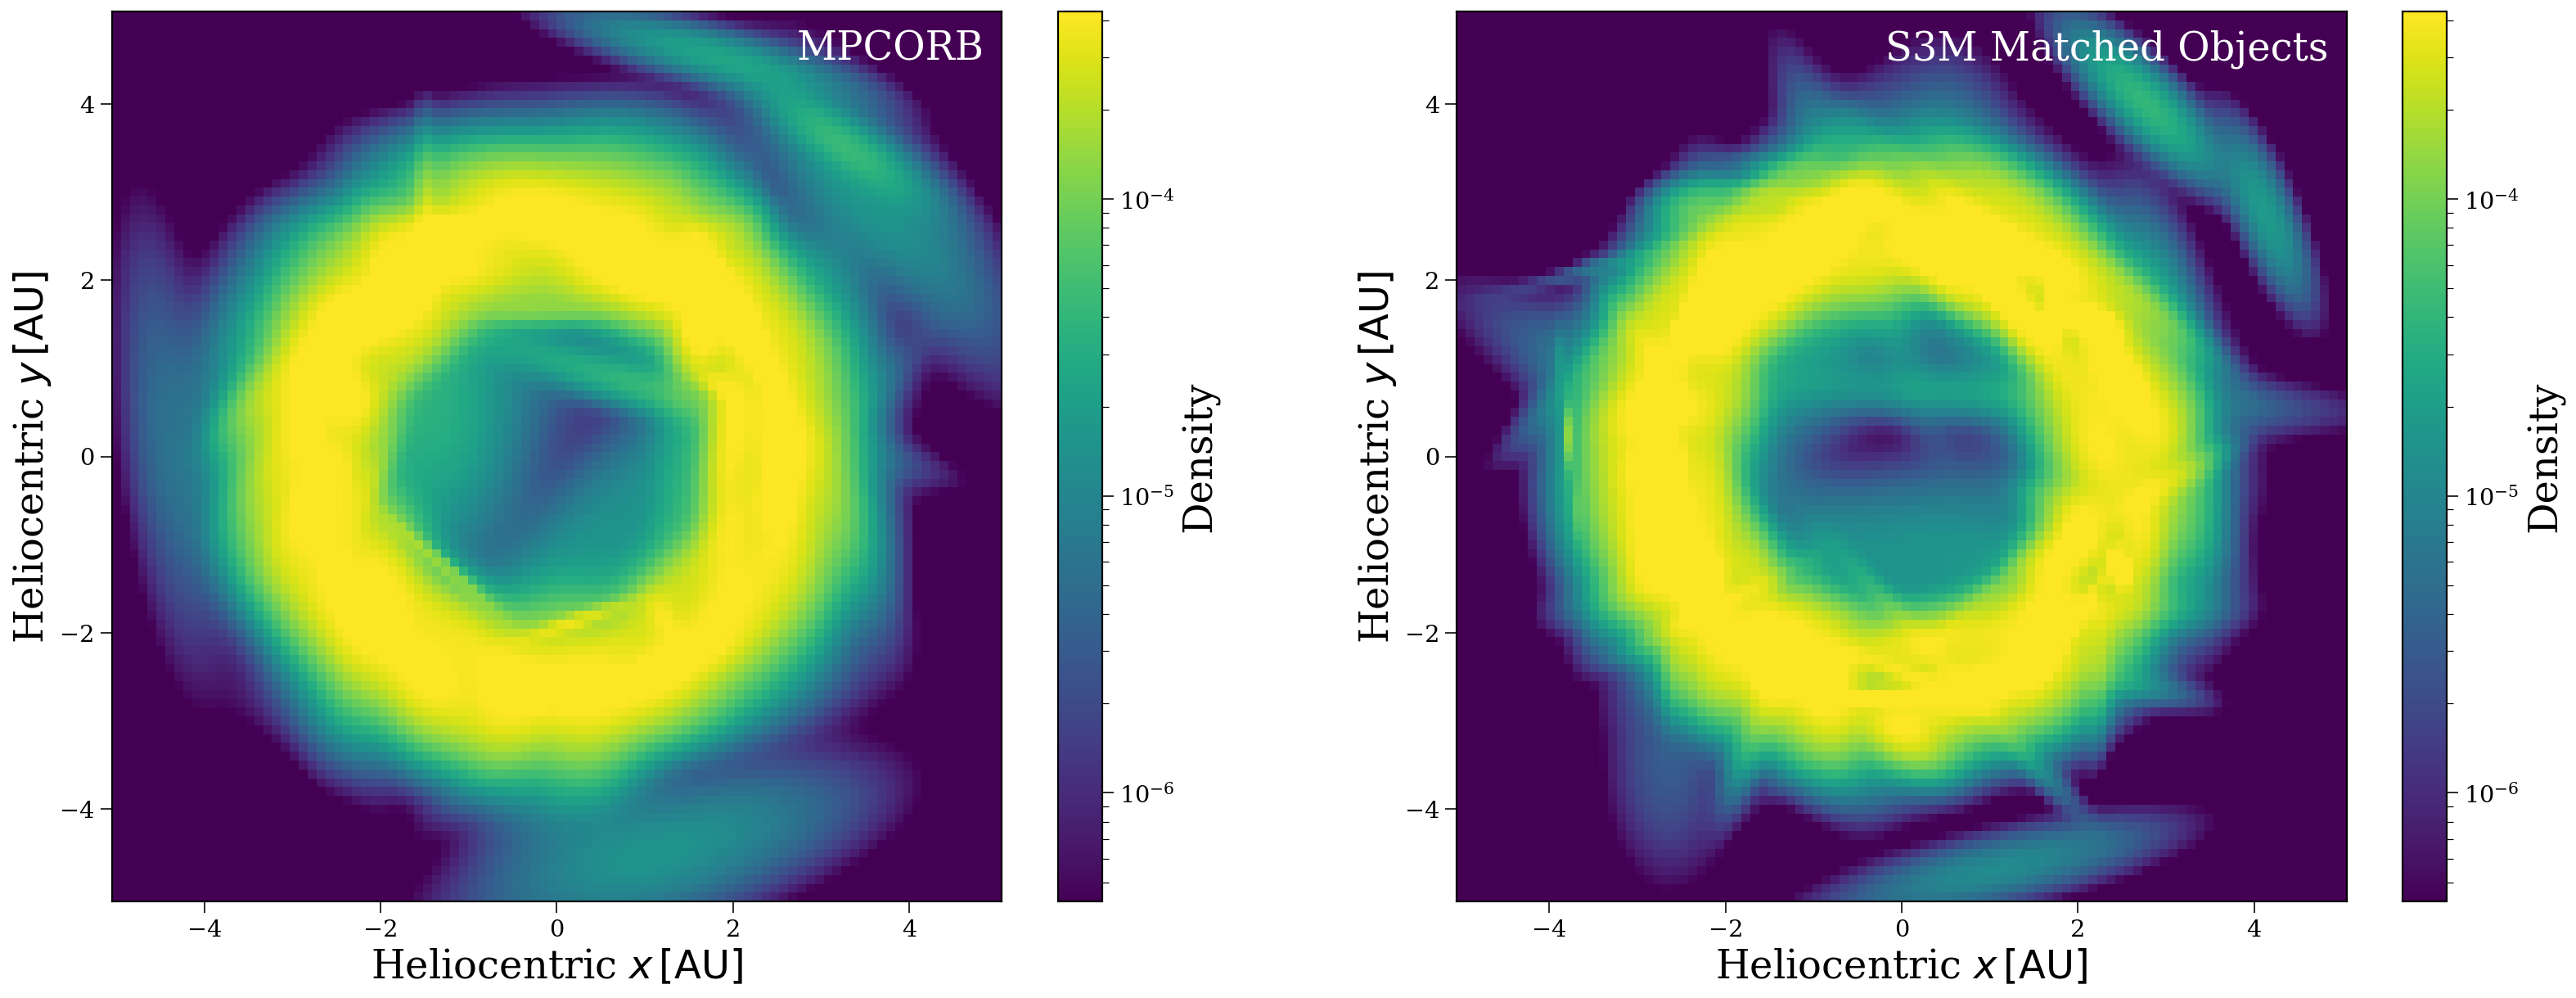

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(27, 10))

fig, axes[0] = plot_x_y_density(gmm_mpc, x, y, grid_shape, label="MPCORB", cmap="viridis", fig=fig, ax=axes[0])
fig, axes[1] = plot_x_y_density(gmm_s3m, x, y, grid_shape, label="S3M Matched Objects", cmap="viridis", fig=fig, ax=axes[1])

plt.show()

### GMM Residuals
I show the residuals for the GMM on the same scale as the one above and you can see the individual values are larger even though the total actually seems to be smaller. However since the distributions are so different this means little.

In [71]:
gmm_res = (gmm_mpc - gmm_s3m).sum()
gmm_res

5.830161657269239e-16

In [72]:
gmm_abs_res = np.abs(gmm_mpc - gmm_s3m).sum()
gmm_abs_res

0.38463393828877573

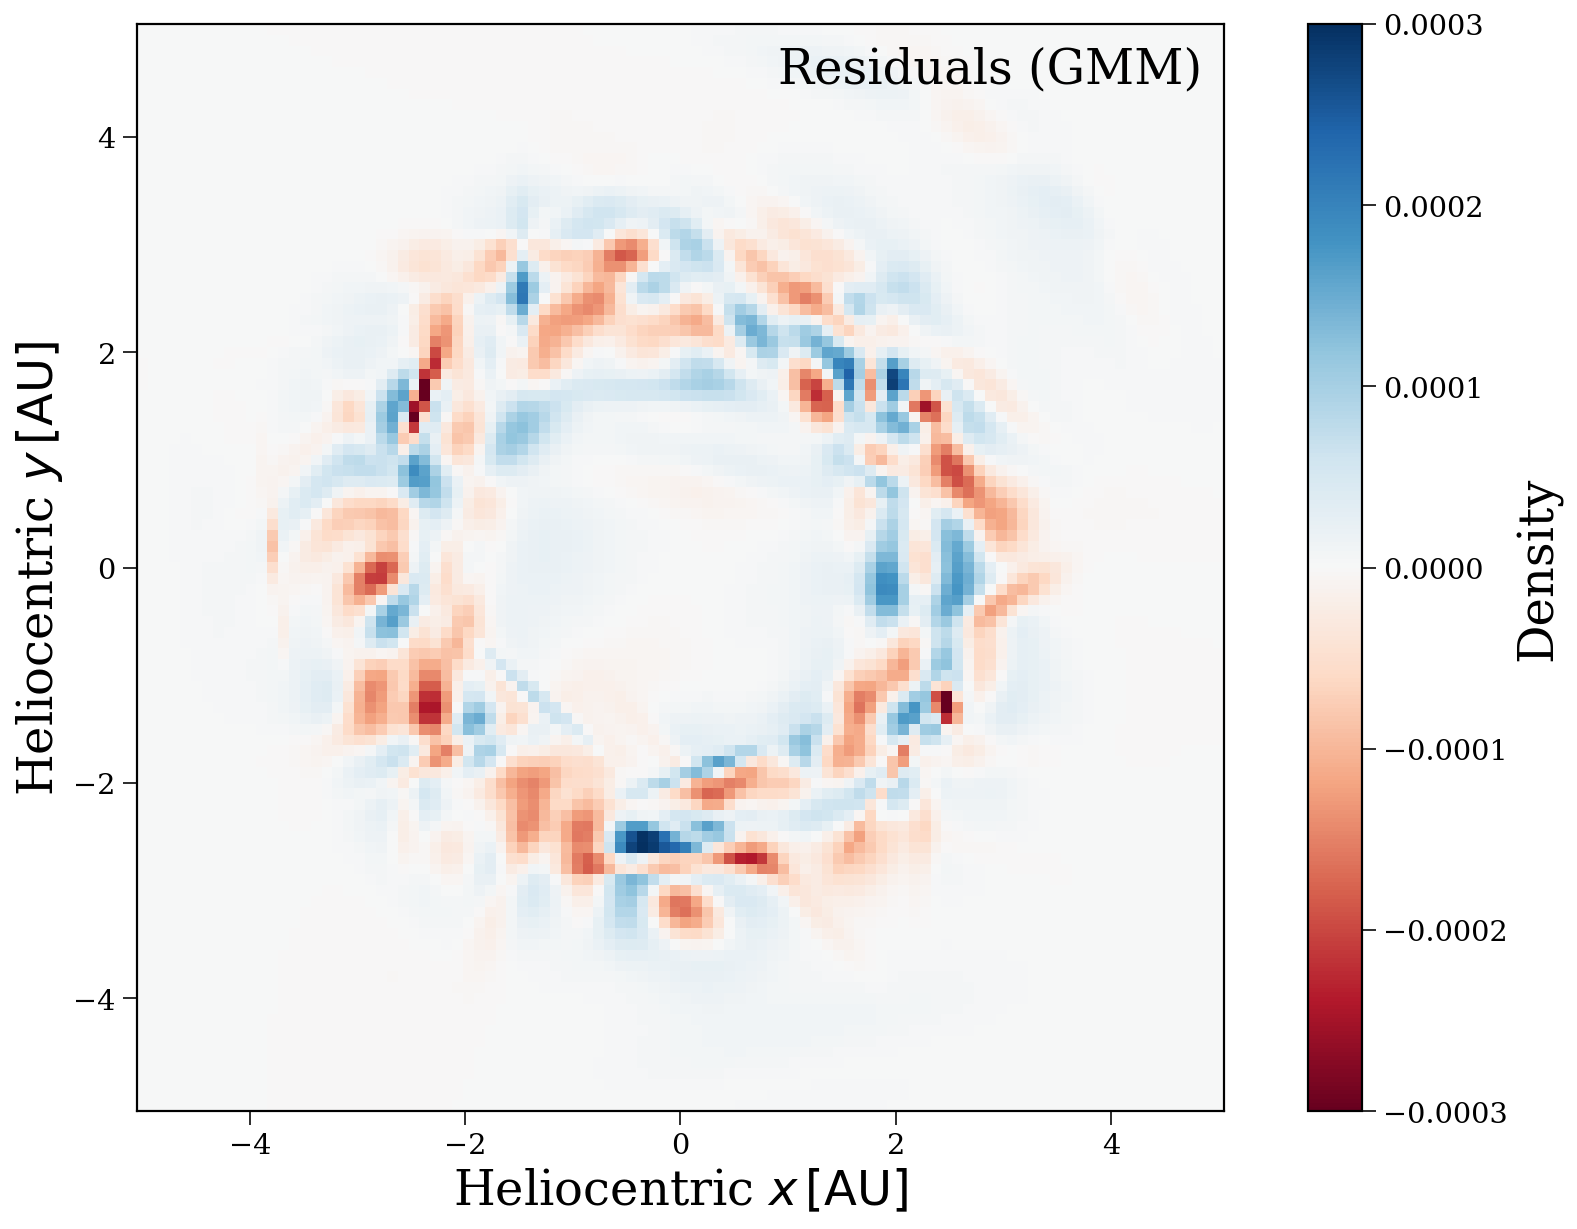

In [70]:
fig, ax = plt.subplots(figsize=(15, 10))

X, Y = np.meshgrid(x, y)
res_img = (gmm_mpc - gmm_s3m).reshape(grid_shape).sum(axis=2).T

ax.annotate("Residuals (GMM)", xy=(0.98, 0.98), xycoords="axes fraction",
                 ha="right", va="top", color="black", fontsize=fs)

mesh = ax.pcolormesh(X, Y, res_img, shading="nearest", cmap="RdBu", norm=Normalize(vmin=-0.0003, vmax=0.0003))
cbar = fig.colorbar(mesh, label="Density", ax=ax)

ax.set_aspect("equal")
ax.set_xlabel(r"Heliocentric $x \, [\rm AU]$")
ax.set_ylabel(r"Heliocentric $y \, [\rm AU]$")

plt.show()

# KL Divergence

## Investigate good threshold values
I found that all sources agree that a KL divergence that is closer to zero is a better match. However, few gave specific thresholds that would tell whether we have a "good" match, rather than just a "better" match than something else.

Therefore, below I try to compare some distributions and find their KL divergences to come up with a good threshold.

### Different distributions comparisons
First, I wondered what would happen if we compared a Gaussian to different distributions. I used a uniform, Cauchy and Maxwellian to try and get a baseline for how much the KL divergence changes.

I find below that the uniform is the most different and the Cauchy is the most similar, as one would expect, but now we have some thresholds would **how** different a uniform is for example.

This hopefully will give some indication of "did I estimate the correct *type* of distribution" with the KL divergence.

In [47]:
norm = scipy.stats.norm(loc=0, scale=1)
uniform = scipy.stats.uniform(loc=-5, scale=10)
cauchy = scipy.stats.cauchy(loc=0, scale=1)
maxwell = scipy.stats.maxwell(loc=-5, scale=2)

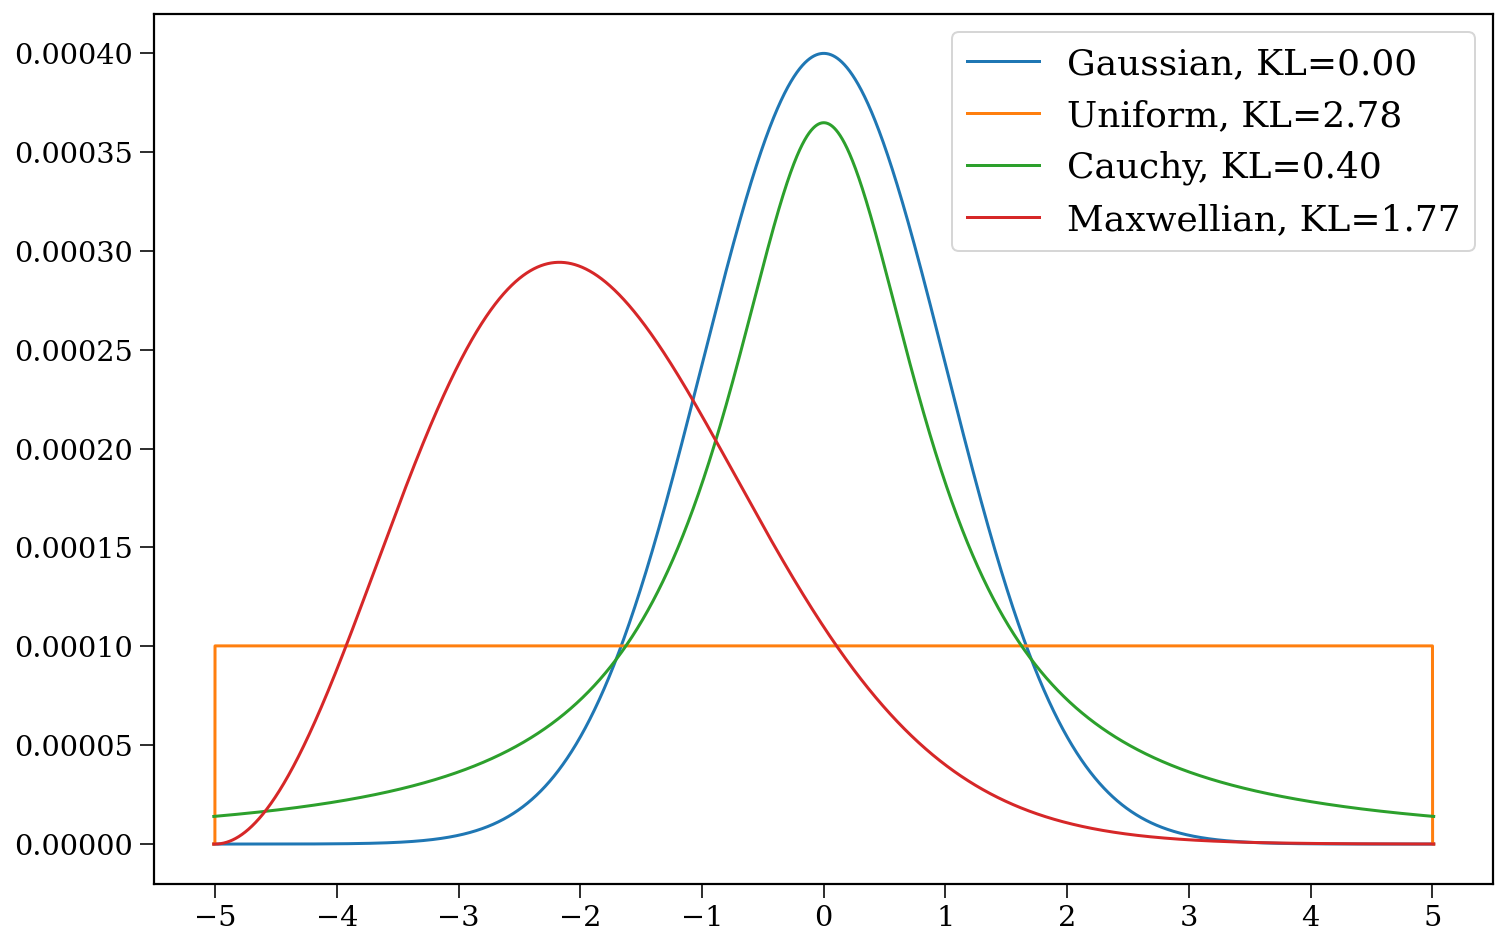

In [48]:
fig, ax = plt.subplots()

x_values = np.linspace(-5.01, 5.01, 10000)

normalised_base_pdf = norm.pdf(x_values) / norm.pdf(x_values).sum()

dists = [norm, uniform, cauchy, maxwell]
labels = ["Gaussian", "Uniform", "Cauchy", "Maxwellian"]

for dist, label in zip(dists, labels):
    normalised_pdf = dist.pdf(x_values) / dist.pdf(x_values).sum()
    kl = rel_entr(normalised_pdf, normalised_base_pdf).sum()
    ax.plot(x_values, normalised_pdf, label="{}, KL={:1.2f}".format(label, kl))
    
ax.legend(fontsize=0.75 * fs)

ax.set_xlim(-5.5, 5.5)
ax.set_xticks(range(-5, 5 + 1))
    
plt.show()

### Gaussian Mixtures

Then I thought it could be interesting to see how well the KL divergence could be used to tell when a mixture of Gaussians is being used.

I find below that the more gaussians you add, the further you move them from the mean and the higher you weight them, the larger you KL as expected. But as before, now we can quantify these differences.

This hopefully will give some indication of "did I manage to avoid adding any features that shouldn't be there?" with the KL divergence.

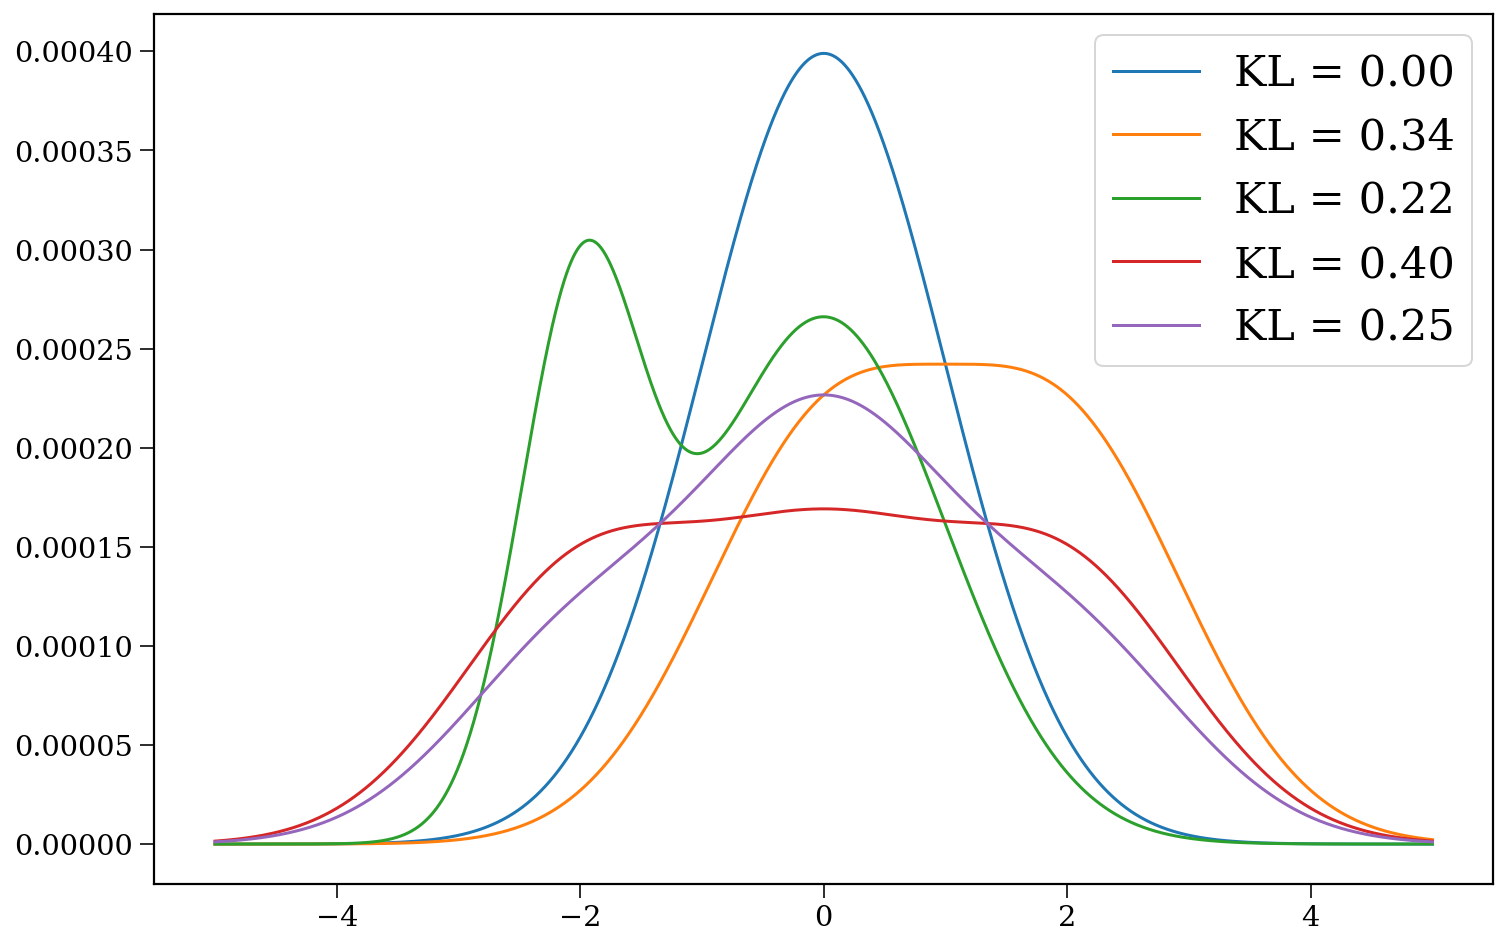

In [49]:
gaussians = [
    [(0, 1, 1)],
    [(0, 1, 1), (2, 1, 1)],
    [(0, 1, 1), (-2, 0.5, 0.5)],
    [(-2, 1, 1), (0, 1, 1), (2, 1, 1)],
    [(-2, 1, 0.5), (0, 1, 1), (2, 1, 0.5)],
]
x_values = np.linspace(-5, 5, 10000)

fig, ax = plt.subplots()

for gaussian in gaussians:
    pdf = np.zeros_like(x_values)
    for loc, scale, weight in gaussian:
        pdf += weight * scipy.stats.norm(loc=loc, scale=scale).pdf(x_values)
    pdf /= pdf.sum()
    
    ax.plot(x_values, pdf, label="KL = {:1.2f}".format(rel_entr(normalised_base_pdf, pdf).sum().round(3)))
    
ax.legend(fontsize=0.9*fs)
    
plt.show()

### Same distribution, different parameters
Finally, let's see how the KL divergence varies for Gaussians with different parameters. We can use this as a gauge for "did I estimate the correct parameters for the distribution?"

It *seeeeems* as though the KL divergence increases roughly linearly with increasing the value of $\sigma$, but it increases more strongly with $\mu$. Means that the KL divergence is more sensitive to offsets rather than scaling issues.

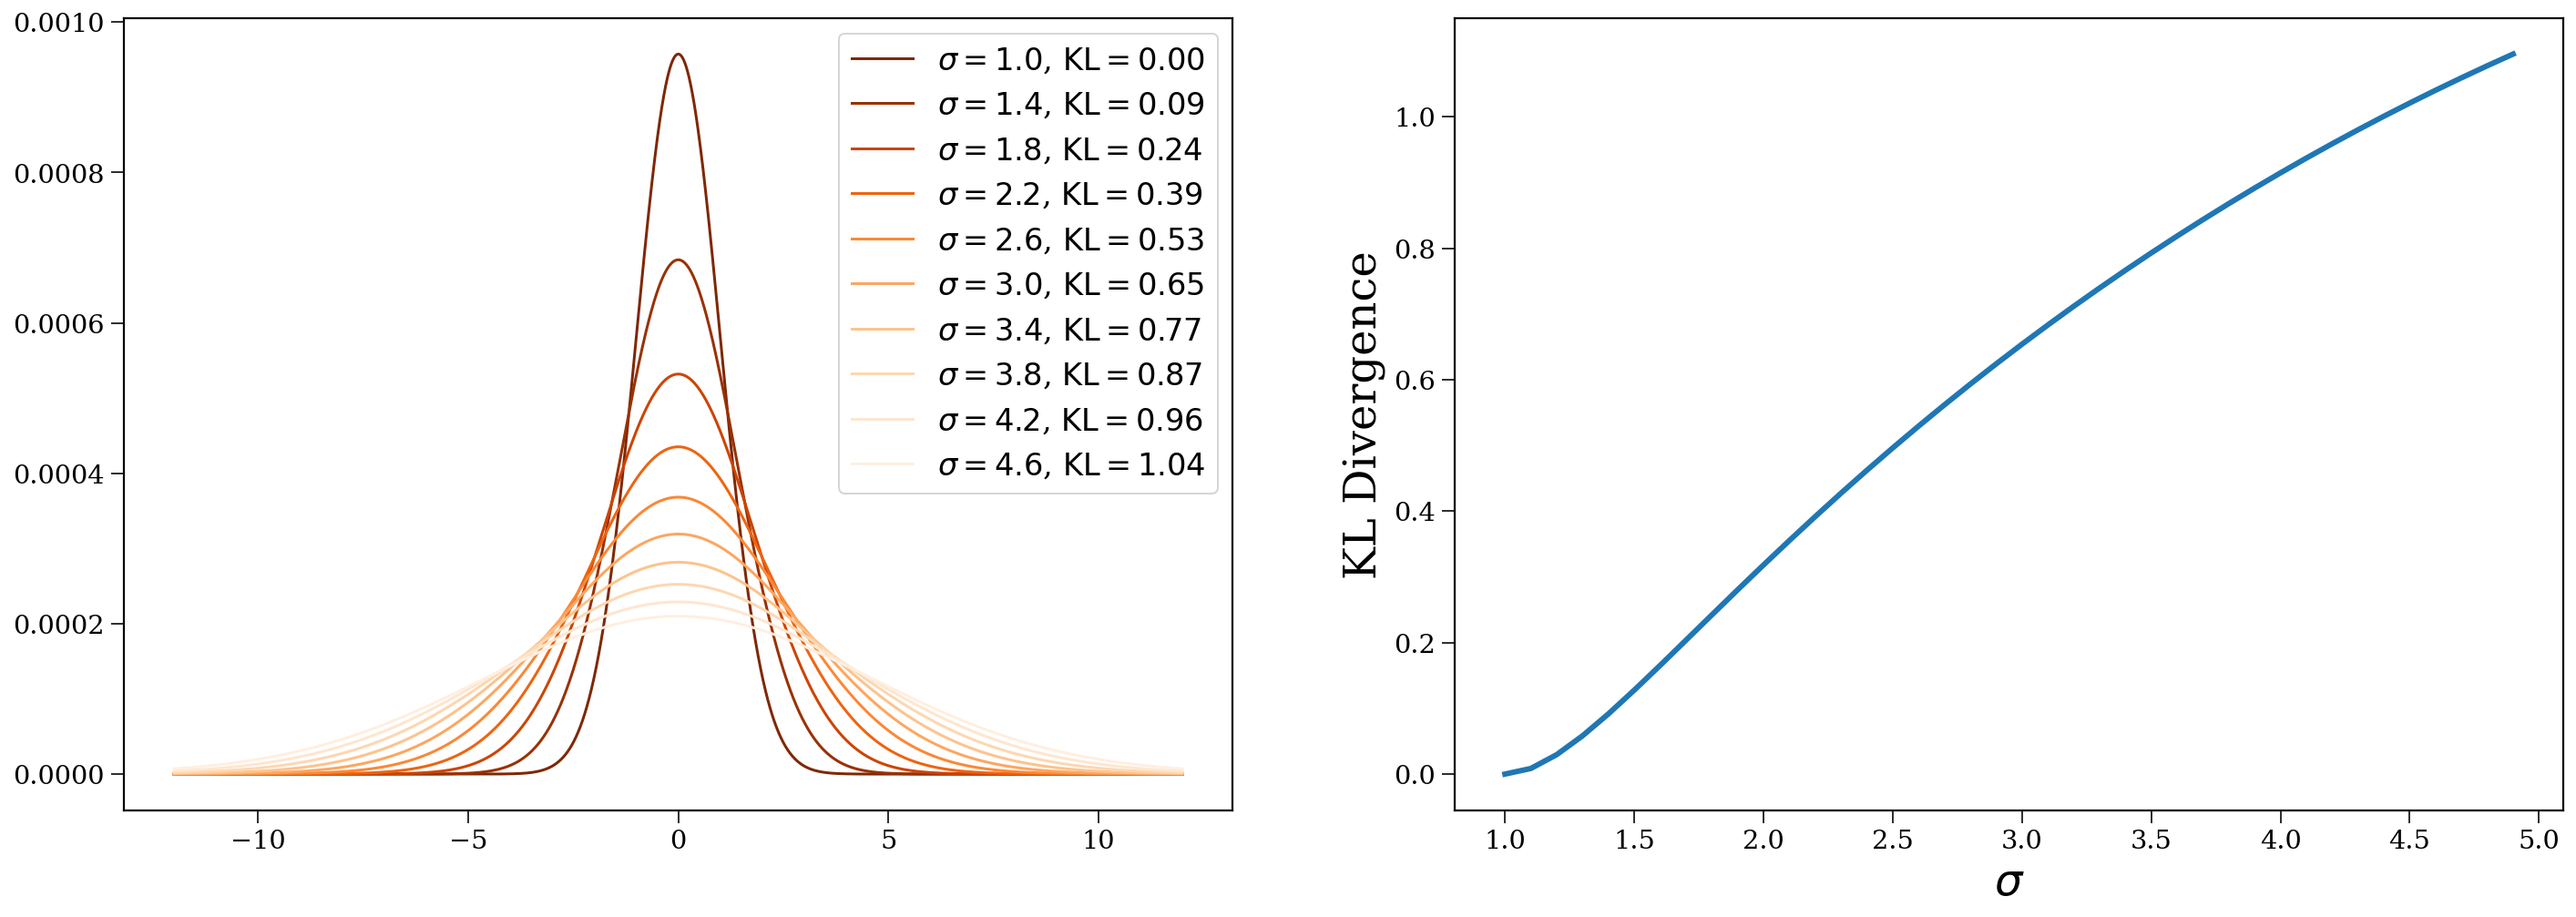

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

x_values = np.linspace(-12, 12, 10000)

base = scipy.stats.norm(loc=0, scale=1)
normalised_base_pdf = base.pdf(x_values)
normalised_base_pdf /= normalised_base_pdf.sum()

scales = np.arange(1, 5, 0.1)
kls = []
pdfs = []


for i, scale in enumerate(scales):
    normalised_pdf = scipy.stats.norm(loc=0, scale=scale).pdf(x_values)
    normalised_pdf /= normalised_pdf.sum()
    pdfs.append(normalised_pdf)
    
    kl = rel_entr(normalised_base_pdf, normalised_pdf).sum()
    kls.append(kl)
    
for i in range(len(scales)):
    if i % 4 == 0:
        axes[0].plot(x_values, pdfs[i], c=plt.get_cmap("Oranges")(1 - kls[i] / max(kls)),
                     label=r"$\sigma={{{:1.1f}}}$, ${{\rm KL}} = {{{:1.2f}}}$".format(scales[i], kls[i]))
    
axes[0].legend(fontsize=0.7 * fs)

axes[1].plot(scales, kls, lw=3)
axes[1].set_xlabel(r"$\sigma$")
axes[1].set_ylabel("KL Divergence")

plt.show()

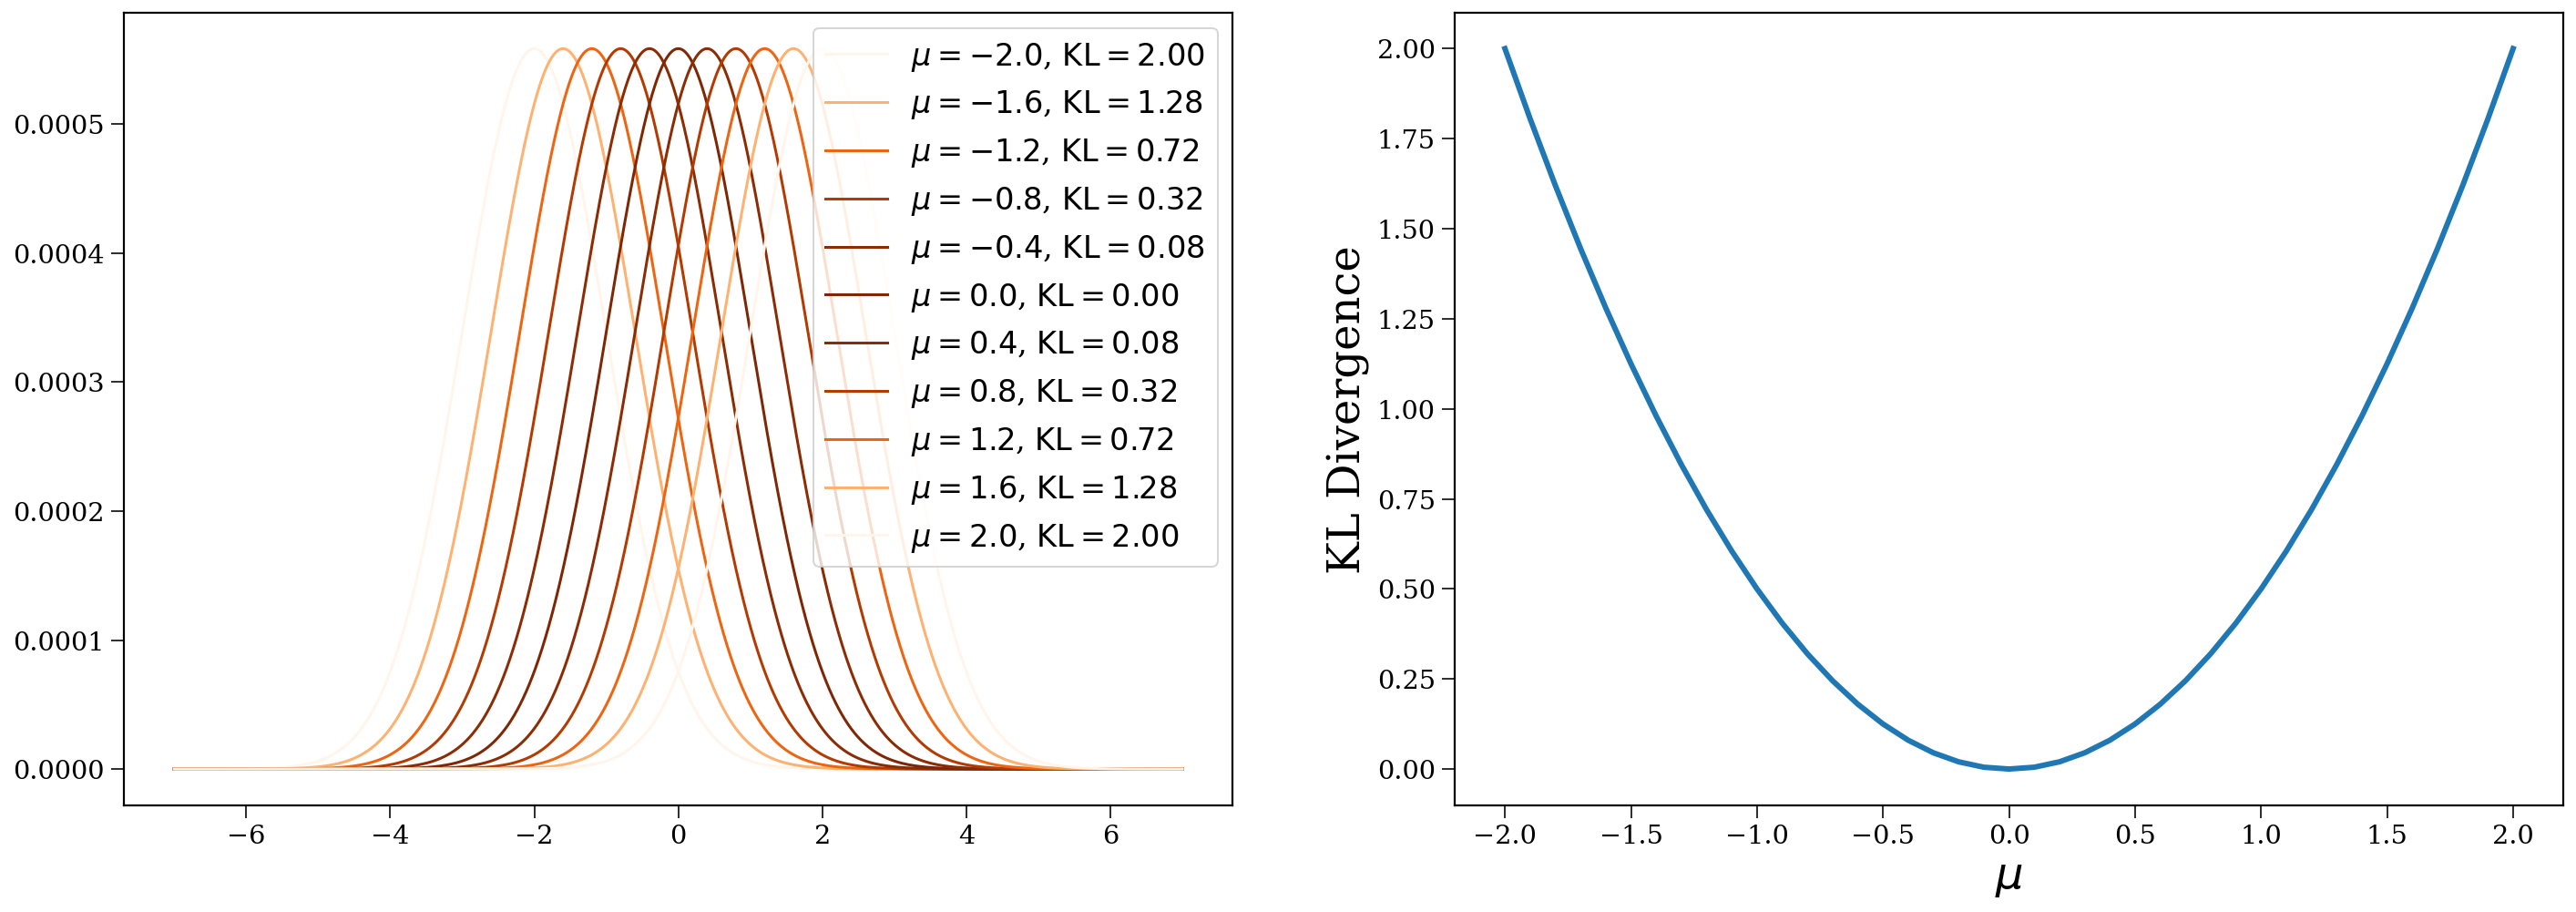

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

x_values = np.linspace(-7, 7, 10000)

base = scipy.stats.norm(loc=0, scale=1)
normalised_base_pdf = base.pdf(x_values)
normalised_base_pdf /= normalised_base_pdf.sum()

locs = np.arange(-2, 2 + 0.1, 0.1)
kls = []
pdfs = []


for i, loc in enumerate(locs):
    normalised_pdf = scipy.stats.norm(loc=loc, scale=1).pdf(x_values)
    normalised_pdf /= normalised_pdf.sum()
    pdfs.append(normalised_pdf)
    
    kl = rel_entr(normalised_base_pdf, normalised_pdf).sum()
    kls.append(kl)
    
for i in range(len(locs)):
    if i % 4 == 0:
        axes[0].plot(x_values, pdfs[i], c=plt.get_cmap("Oranges")(1 - kls[i] / max(kls)),
                     label=r"$\mu={{{:1.1f}}}$, ${{\rm KL}} = {{{:1.2f}}}$".format(locs[i], kls[i]))
    
axes[0].legend(fontsize=0.7 * fs)

axes[1].plot(locs, kls, lw=3)
axes[1].set_xlabel(r"$\mu$")
axes[1].set_ylabel("KL Divergence")

plt.show()

## Is Laplacian Smoothing useful?
Nope :D I considered using some smoothing which would look something like the following function

In [52]:
def smoothed_rel_entr(a, b):
    smoothing_a = np.ones_like(a) * a.min()
    smoothing_b = np.ones_like(b) * b.min()
    
    return rel_entr(a + smoothing_a, b + smoothing_b)

However, this tends to give the same values for the KL divergences. This is because the densities don't actually seem to have any zero values which would causes issues. Therefore I didn't add this to the densities below.

In [53]:
np.any(mpc_density == 0.0) or np.any(mpc_density_zoomed == 0.0)\
    or np.any(s3m_density == 0.0) or np.any(s3m_density_zoomed == 0.0)

False

## Calculate KL for densities
So first, we can calculate the KL divergence for the zoomed in densities since I thought those looked much similar in the plots.

In [54]:
rel_entr(mpc_density_zoomed, s3m_density_zoomed).sum().round(4)

0.1486

But the fun thing is that the value is pretty much the same for the zoomed out density. This makes sense since they only looked different in very low density regimes. As I showed above, we only actually cut out around 0.8% of the original density so it does make sense.

In [55]:
rel_entr(mpc_density, s3m_density).sum().round(4)

0.1502

## Evaluate whether this is acceptable

I found that the KL divergence is about 0.15 for comparing the real density to the simulated one. We can compare this to the threshold values for different distributions and parameters that I showed above.

First, I think the obvious good news is that this value is lower than those found when comparing different distributions to a Gaussian. This means that the match is better than between two different distributions so that's really the least we could hope for!

Each of the values are also smaller than those for the examples of Gaussian mixtures that I tried as well, I tried to use this as a proxy for "did I add any features to the distribution which were not there". Since the values are better I argue that this means I haven't added any large features that deviate from the original distribution.

Finally, the value of 0.15 is of course not the lowest possible value but it does indicate that the parameters of the distribution are not *too* far off.

### Note about zero

We should also acknowledge that a value of zero would not be a good thing in the case of this project. There will **never** be an exact match for MPC objects in the S3M catalogue. This means that we could only get a value of zero if the density estimation was somehow over smoothing (or perhaps had too few bins in the grid).

# Summary

In summary, using K Nearest Neighbours density estimation and KL divergence, I found that the hybrid catalogue seems to perform well and the matched simulated data closely resembles the real data! :D

Thanks for a great semester and all of your teaching/help! :)